### 0. Imports and requirements

* Для моделирования нам понадобится реализация градиентного бустинга из `catboost` и `lightgbm`. Для обработки данных - стандартный DS стек из `pandas`, `numpy` и `sklearn`. Так как мы будем использовать по-настоящему огромные выборки (логи транзакций клиентов), то нужно будет эффективно читать данные и выделять из них признаки, чтобы иметь возможность строить решение даже на локальных машинах с большими ограничениями по RAM.  Поэтому нам понадобятся инструменты для работы с форматом данных `Parquet`. Библиотека `pandas` представляет необходимый инструментарий (рекомендуем установить модуль `fastparquet`, это позволит еще быстрее считывать данные).

In [1]:
%load_ext autoreload
%autoreload 2

import gc

import os
import sys
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

import catboost as cb
import lightgbm as lgb

pd.set_option('display.max_columns', None)

# если у вас есть CUDA, то она понадобится там для экспериментов в catboost
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

sys.path.append('../')

### 1. Reading Data

* В данном соревновании участникам предстоит работать с таким форматом данных, как `Parquet`. Подробнее о нем почитать Вы можете самостоятельно. Самое главное - это крайне эффективный бинарный формат сжатия данных по колонокам. Однако для непосредственной работы с данными и построением моделей, нам нужно их прочитать и трансформировать в pandas.DataFrame. При этом сделать это эффективно по памяти.

In [2]:
TRAIN_TRANSACTIONS_PATH = '../DATA/train_transactions_contest/'
TEST_TRANSACTIONS_PATH = '../DATA/test_transactions_contest/'

TRAIN_TARGET_PATH = '../DATA/train_target.csv'
PRE_TRANSACTIONS_PATH = '../DATA/preprocessed_transactions/'
PRE_TEST_TRANSACTIONS_PATH = '../DATA/preprocessed_test_transactions/'


In [3]:
from utils import read_parquet_dataset_from_local, eda_value_counts

* Для примера прочитаем одну партицию в память и оценим, сколько RAM она занимает

In [4]:
transactions_frame = read_parquet_dataset_from_local(TRAIN_TRANSACTIONS_PATH, start_from=0, num_parts_to_read=1)

memory_usage_of_frame = transactions_frame.memory_usage(index=True).sum() / 10**9
expected_memory_usage = memory_usage_of_frame * 50
print(f'Объем памяти в  RAM одной партиции данных с транзакциями: {round(memory_usage_of_frame, 3)} Gb')
print(f'Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} Gb')

FileNotFoundError: [Errno 2] No such file or directory: '../DATA/train_transactions_contest/'

* Итого, если у вас обычный локальный компьютер, то скорее всего весь датасет в памяти не уместится - вам потребуется значительный объем RAM или дополнительные ресурсы. Решение - читать данные итеративно. Партиции организованы таким образом, что  для конкретного клиента вся информация о его транзакциях до момента подачи заявки на кредит расположена внутри одной партиции (транзакции сгруппированы по полю `app_id`). Это позволяет загружать данные в память кусками, выделять все необходимые признаки и получать результирующий фрейм для моделирования. Для этих целей мы предоставляем вам функцию `utils.read_parquet_dataset_from_local`.

Так же все партиции с транзакциями упорядочены по возрастанию даты.

In [6]:
del transactions_frame
gc.collect()

28

### 2. Feature Extraction

* В рамках конкурса участникам предстоит работать с историей транзакций клиентов. На основе истории транзакций нужно оценить насколько благонадежным является клиент и определить, шансы того, что он уйдет в дефолт. В качестве признаков участники будут использовать характеристики клиентских транзакций: сумму транзакции, категорию транзакции, время и многие другие. Подробнее можно будет узнать на странице конкурса.


* Для бейзлайна мы подготовили функцию `features.extract_basic_aggregations`, она делает следующее:
     * на основе признака суммы транзакции `amnt` строит pivot_table для указанных категориальных признаков `cat_columns` и перечисленных функций агрегации. То есть, например, если в качестве агрегирующих функций указаны ['sum', 'mean', 'count'] и ['mcc_category'] в качестве `cat_columns`, то будут посчитаны общая сумма/среднее/количество транзакций по каждой конкретной категории признака `mcc_category`. Признаки расчитываются на основе фрейма транзакций для каждого клиента. 
     
     * Для численных признаков, таких как `amnt`, `hour_diff`, `days_before` расчитываются осмысленные статистики: минимум/максмимум/медиана/среднее...
     
     
 * Для обработки лога транзакций предлагается использовать функцию `prepare_transactions_dataset` ниже:

In [7]:
!rm -r {PRE_TRANSACTIONS_PATH}
!mkdir {PRE_TRANSACTIONS_PATH}

In [8]:
from features import extract_basic_aggregations

def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50, 
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи.
    path_to_dataset: str  
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int 
        количество партиций, которые будут одновременно держаться в памяти и обрабатываться
    num_parts_total: int 
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранен каждый обработанный блок в .parquet формате. Если None, то не будет сохранен 
    verbose: bool
        логирует каждый обрабатываемый кусок данных
    """
    preprocessed_frames = []
    block = 0
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, 
                                                             verbose=verbose)
        features = extract_basic_aggregations(transactions_frame, 
                                              cat_columns=['mcc_category', 'day_of_week', 'operation_type'])
        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            features.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
            
        preprocessed_frames.append(features)
    return pd.concat(preprocessed_frames)

In [10]:
data = prepare_transactions_dataset(TRAIN_TRANSACTIONS_PATH, num_parts_to_preprocess_at_once=10, num_parts_total=50, 
                                    save_to_path=PRE_TRANSACTIONS_PATH)

Transforming transactions data:   0%|          | 0/5 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
data.sample()

,app_id,count_mcc_category_1,count_mcc_category_2,count_mcc_category_3,count_mcc_category_4,count_mcc_category_5,count_mcc_category_6,count_mcc_category_7,count_mcc_category_8,count_mcc_category_9,count_mcc_category_10,count_mcc_category_11,count_mcc_category_12,count_mcc_category_13,count_mcc_category_14,count_mcc_category_15,count_mcc_category_16,count_mcc_category_17,count_mcc_category_18,count_mcc_category_19,count_mcc_category_20,count_mcc_category_21,count_mcc_category_22,count_mcc_category_23,count_mcc_category_24,count_mcc_category_25,count_mcc_category_26,count_mcc_category_27,count_mcc_category_28,mean_mcc_category_1,mean_mcc_category_2,mean_mcc_category_3,mean_mcc_category_4,mean_mcc_category_5,mean_mcc_category_6,mean_mcc_category_7,mean_mcc_category_8,mean_mcc_category_9,mean_mcc_category_10,mean_mcc_category_11,mean_mcc_category_12,mean_mcc_category_13,mean_mcc_category_14,mean_mcc_category_15,mean_mcc_category_16,mean_mcc_category_17,mean_mcc_category_18,mean_mcc_category_19,mean_mcc_category_20,mean_mcc_category_21,mean_mcc_category_22,mean_mcc_category_23,mean_mcc_category_24,mean_mcc_category_25,mean_mcc_category_26,mean_mcc_category_27,mean_mcc_category_28,count_day_of_week_1,count_day_of_week_2,count_day_of_week_3,count_day_of_week_4,count_day_of_week_5,count_day_of_week_6,count_day_of_week_7,mean_day_of_week_1,mean_day_of_week_2,mean_day_of_week_3,mean_day_of_week_4,mean_day_of_week_5,mean_day_of_week_6,mean_day_of_week_7,count_operation_type_1,count_operation_type_2,count_operation_type_3,count_operation_type_4,count_operation_type_5,count_operation_type_6,count_operation_type_7,count_operation_type_8,count_operation_type_9,count_operation_type_10,count_operation_type_11,count_operation_type_12,count_operation_type_13,count_operation_type_14,count_operation_type_15,count_operation_type_16,count_operation_type_17,count_operation_type_18,count_operation_type_19,count_operation_type_20,count_operation_type_21,count_operation_type_22,mean_operation_type_1,mean_operation_type_2,mean_operation_type_3,mean_operation_type_4,mean_operation_type_5,mean_operation_type_6,mean_operation_type_7,mean_operation_type_8,mean_operation_type_9,mean_operation_type_10,mean_operation_type_11,mean_operation_type_12,mean_operation_type_13,mean_operation_type_14,mean_operation_type_15,mean_operation_type_16,mean_operation_type_17,mean_operation_type_18,mean_operation_type_19,mean_operation_type_20,mean_operation_type_21,mean_operation_type_22,amnt_mean,amnt_median,amnt_sum,amnt_std,hour_diff_max,hour_diff_mean,hour_diff_median,hour_diff_var,hour_diff_std,days_before_min,days_before_max,days_before_median
62070,64503,106,23,19,26,50,40,4,0,6,17,6,1,3,7,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0.319783,0.463942,0.3016,0.304672,0.329605,0.289528,0.337116,0.0,0.409068,0.349253,0.309005,0.325749,0.318541,0.351192,0.0,0.0,0.0,0.27949,0.0,0.0,0.0,0.398641,0.0,0.0,0.0,0.0,0.0,0.0,38,35,50,59,43,39,48,0.363201,0.334758,0.316364,0.328377,0.338538,0.309052,0.323567,285,3,0,23,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.319377,0.27949,0.0,0.463942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320341,0.0,0.0,0,0.0,0.0,0.329654,0.312236,102.851976,0.07054,895,27.538462,5.0,6369.21395,79.807355,1,359,181.0


In [12]:
print(f'Объем в RAM всего датасета: {round(data.memory_usage(index=True).sum() / 10**9, 3)} Gb')

Объем в RAM всего датасета: 0.979 Gb


* Обработаем тестовый набор данных и выделим все признаки:

In [13]:
! rm -r {PRE_TEST_TRANSACTIONS_PATH}
! mkdir {PRE_TEST_TRANSACTIONS_PATH}

In [14]:
test_data = prepare_transactions_dataset(TEST_TRANSACTIONS_PATH, num_parts_to_preprocess_at_once=10, num_parts_total=50, 
                                         save_to_path=PRE_TEST_TRANSACTIONS_PATH)

Transforming transactions data:   0%|          | 0/5 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
TEST_TARGET_PATH = '../DATA/test_target_contest.csv'
test_target =  pd.read_csv(TEST_TARGET_PATH)
test_target.head()

,app_id,product
0,1063620,0
1,1063621,0
2,1063622,1
3,1063623,1
4,1063624,2


In [16]:
merged_test_data = test_data.merge(test_target[['app_id', 'product']], on='app_id')

* теперь можно переходить к моделированию и экспериментам. зафиксируем целевую метрику - `ROC AUC`. Результатом всех экспериментов будут серия следующих моделей:

| Name | Train | CV | Public Test|число признаков
| :-: | :-: | :-: | :-: | :-: |
| lgb+cv(5) | 0.801 | 0.77 |  0.737 | 127
|catboost+cv(5)| 0.775| 0.764 | 0.732 | 127
|lgb+cv(5)+split_importance(top 64 feats)| 0.795| 0.767 | 0.735| 64
| lgb+cv(5)+permutation_importance(top 57 feats) | 0.796 | 0.768 |  0.736 | 57
| lgb+cv(5)+target_permutation(top 60 feats) | 0.796 | 0.766 |  0.733 | 60

* Вы можете перейти сразу же к интересующему вас подходу и скорее приниять участие в конкурсе!

### 3. LightGBM + CV

* Начнем с градиентного бустинга из библиотеки `LightGBM`. Самое главное - всегда выделять валидационную выборку, чтобы контролировать обучение и не переобучаться. Можно выделять отложенную выборку по времени, случайную выборку,  использовать стратифицированное разбиение по целевой переменной или кросс-валидацию.

In [17]:
targets = pd.read_csv(TRAIN_TARGET_PATH)
targets.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


* Добавим целевую переменную `flag`  и признак `product` к выделенным агрегациям по клиентам

In [18]:
merged_data = data.merge(targets[['app_id', 'product', 'flag']], on=['app_id'])

In [19]:
features = [x for x in merged_data.columns if x not in ['app_id', 'flag']]

In [20]:
%%time
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': -1,
    'n_estimators': 1000,
    'device': 'gpu'
}

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[features], train.flag.values, eval_set=[(val[features], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[features])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[features])[:, 1] / (cv.n_splits-1)
    models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.733569
[100]	valid_0's auc: 0.745821
[150]	valid_0's auc: 0.751263
[200]	valid_0's auc: 0.755033
[250]	valid_0's auc: 0.757651
[300]	valid_0's auc: 0.759576
[350]	valid_0's auc: 0.760943
[400]	valid_0's auc: 0.762048
[450]	valid_0's auc: 0.763016
[500]	valid_0's auc: 0.763795
[550]	valid_0's auc: 0.764479
[600]	valid_0's auc: 0.765153
[650]	valid_0's auc: 0.765673
[700]	valid_0's auc: 0.766305
[750]	valid_0's auc: 0.766688
[800]	valid_0's auc: 0.767083
[850]	valid_0's auc: 0.767342
[900]	valid_0's auc: 0.7677
[950]	valid_0's auc: 0.768008
[1000]	valid_0's auc: 0.768269
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.768277
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.735806
[100]	valid_0's auc: 0.748626
[150]	valid_0's auc: 0.754227
[200]	valid_0's auc: 

In [28]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.7961201005870615)

In [29]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7682259122001022)

* Подготовим посылку в проверяющую систему:

In [30]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(models):
    score += model.predict_proba(merged_test_data[features])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) 

submission.to_csv('sub.csv', index=None) # ~ 0.737 roc-auc на public test

  0%|          | 0/5 [00:00<?, ?it/s]

### 4.  Виды Feature Importance

* Важный шаг в построении моделей - оценка важности признаков. `LightGBM` имеет внутренние способы оценки важности признаков - на основе того, как часто делается сплит в вершине по признаку (`split`) и на основе того, какой суммарный прирост в информации дает разбиение по признаку (`gain`). Используем первый способ оценки важности признаков. Затем отберем топ признаков по важности и построим на них новые модели.

In [31]:
importances = np.zeros(len(features))
for model in models:
    importances += model.feature_importances_ / len(models)

In [32]:
def plot_feature_importance(feature_names, feature_scores, top_feats=20, title='Importance', x_label='Importance', 
                            y_label='Features'):
    tuples = [(name, round(score, 3)) for name, score in zip(feature_names, feature_scores)]
    tuples = sorted(tuples, key=lambda x: x[1])[-top_feats:]
    
    labels, values = zip(*tuples)
    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    ylocs = np.arange(len(values))
    
    ax.barh(ylocs, values, align='center', height=0.4)
    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, x, va='center')
        
    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)
    ylim = (-1, len(values))
    ax.set_ylim(ylim)
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)

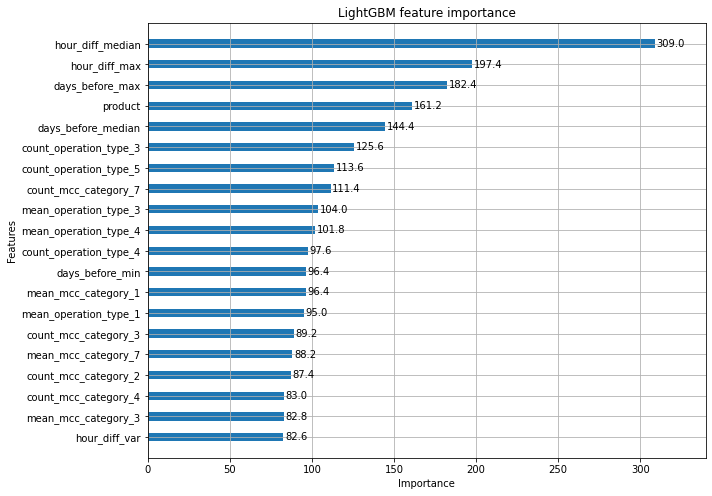

In [25]:
plot_feature_importance(features, importances, top_feats=20, title='LightGBM feature importance', 
                        x_label='Importance')

In [33]:
tuples = [(name, round(score, 3)) for name, score in zip(features, importances)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] >= np.median(importances)]

In [34]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.732058
[100]	valid_0's auc: 0.743787
[150]	valid_0's auc: 0.749116
[200]	valid_0's auc: 0.752729
[250]	valid_0's auc: 0.754767
[300]	valid_0's auc: 0.756715
[350]	valid_0's auc: 0.758151
[400]	valid_0's auc: 0.759096
[450]	valid_0's auc: 0.759782
[500]	valid_0's auc: 0.760652
[550]	valid_0's auc: 0.76129
[600]	valid_0's auc: 0.76188
[650]	valid_0's auc: 0.762633
[700]	valid_0's auc: 0.762904
[750]	valid_0's auc: 0.763385
[800]	valid_0's auc: 0.763731
[850]	valid_0's auc: 0.764199
[900]	valid_0's auc: 0.764353
[950]	valid_0's auc: 0.764645
[1000]	valid_0's auc: 0.764941
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.764942
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.734711
[100]	valid_0's auc: 0.748002
[150]	valid_0's auc: 0.753177
[200]	valid_0's auc: 

In [28]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.7964627929564552)

In [29]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7683256742004549)

In [30]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.7346 на public test

* Другой эффективный и простой способ оценки важности признаков - `permutation importance`. Такой способ оценки важности признаков можно применить к любой обученной модели на табличных данных. Данный тип важности определеяется для каждого признака, как изменение в скоре (в нашем случае - `roc_auc`) при случайном перемешиваниии столбца  с значениями этого признака несколько раз. Можно использовть реализацию из `sklearn`.

In [35]:
permut_importance = np.zeros(len(features))

for fold_, (_, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Compute with fold {fold_} started.')
    val = merged_data.iloc[val_idx]
    importances_report = permutation_importance(models[fold_-1], val[features], val.flag.values, n_repeats=3, 
                                     n_jobs=-1, scoring='roc_auc')
    permut_importance += importances_report.importances_mean / cv.n_splits
    print(f'Computation with fold {fold_} completed.')

Compute with fold 1 started.
Computation with fold 1 completed.
Compute with fold 2 started.
Computation with fold 2 completed.
Compute with fold 3 started.
Computation with fold 3 completed.
Compute with fold 4 started.
Computation with fold 4 completed.
Compute with fold 5 started.
Computation with fold 5 completed.


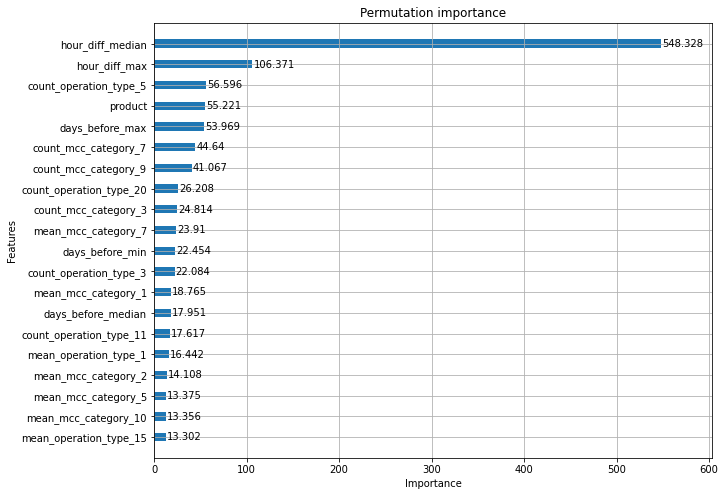

In [36]:
plot_feature_importance(features, permut_importance*10000, top_feats=20, title='Permutation importance', 
                        x_label='Importance')

* Используя техники оценки важности признаков можно интерпретировать модель, пытаться генерировать новые признаки или упрощать модель, удаляя самые неинформативные. Попробуем оставить топ информативных признаков (с точки зрения) `permutation importance`. Удаление из модели признаков, как правило, уменьшает ее склонность к переобучению. А самое главное - может существенно ускорить процесс обучения и последующий процесс использования ее в продуктовых целях.

In [37]:
tuples = [(name, round(score, 3)) for name, score in zip(features, permut_importance)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] > 0]

In [38]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.731829
[100]	valid_0's auc: 0.744662
[150]	valid_0's auc: 0.750178
[200]	valid_0's auc: 0.753634
[250]	valid_0's auc: 0.756363
[300]	valid_0's auc: 0.758285
[350]	valid_0's auc: 0.75971
[400]	valid_0's auc: 0.760899
[450]	valid_0's auc: 0.762117
[500]	valid_0's auc: 0.762918
[550]	valid_0's auc: 0.76361
[600]	valid_0's auc: 0.764293
[650]	valid_0's auc: 0.764761
[700]	valid_0's auc: 0.765182
[750]	valid_0's auc: 0.765649
[800]	valid_0's auc: 0.76607
[850]	valid_0's auc: 0.766251
[900]	valid_0's auc: 0.766534
[950]	valid_0's auc: 0.766621
[1000]	valid_0's auc: 0.766844
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.766844
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.735958
[100]	valid_0's auc: 0.748441
[150]	valid_0's auc: 0.753811
[200]	valid_0's auc: 

In [39]:
'Train roc-auc', roc_auc_score(targets, train_preds)

('Train roc-auc', 0.7967036799969928)

In [40]:
'CV roc-auc', roc_auc_score(targets, oof)

('CV roc-auc', 0.7697722576410979)

In [41]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.736 roc-auc на public test

  0%|          | 0/5 [00:00<?, ?it/s]

* Можно попробовать продвинутые способы изучения предсказаний модели - `SHAP values`. Мы используем так называемый `summary plot`, позволяющий получить общую картину о влиянии того или иного признака на предсказание модели визуализуруя всю выборку сразу.

In [ ]:
train, val = train_test_split(merged_data, random_state=42, test_size=0.1)

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'seed': 100,
    'n_jobs': 5,
    'n_estimators': 1000
}

lgb_model = lgb.LGBMClassifier(**tree_params)
lgb_model.fit(train[features], train.flag.values, eval_set=[(val[features], val.flag.values)],
              early_stopping_rounds=50, verbose=-1)

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(lgb_model)

In [ ]:
shap_values = explainer.shap_values(val[features])

* результаты довольно хорошо согласуются с перестановочной важностью.

* что показывает этот график:
    * по вертикали отложена каждая фича
    * каждая точка графика - признак некоторого сэмпла
    * цвет - значение фичи, чем краснее - тем значение фичи выше, и наоборот
    * горизонтальное положение точки показывает, приводит ли значение конкретной фичи этого сэмпла к росту предсказания, или наоборот. Например, из графика можно увидеть тренд, что уменьшение признака `hour_diff_median` приводит к росту значения целевой переменной.

In [ ]:
shap.summary_plot(shap_values[1], val[features])

* Еще одна интересная техника оценки важности и отбора признаков - `target permutation`


* Отбор признаков через `target permutation` основан на сравнении важности признака, которая быал получена при обучении на обычной выборке, с распределением важности этого признака для моделей, которые обучены на выборках с перемешанной целевой переменной.

In [ ]:
def get_feature_importances(frame, shuffle=False, seed=100, importance_type='gain'):
    # запишем целевую target в переменную
    y = frame.flag.values.copy()
    if shuffle:
        # перемешаем целевую переменную
        y = frame.flag.copy().sample(frac=1.0).values
    
    # обучим случайный лес из LightGBM ( реализация гораздо быстрее, чем в sklearn )
    # сделаем это для того, чтобы не выделять отдельную выборку под валидацию для градиентного бустинга
    tree_params = {
    'objective': 'binary',
    'boosting_type': 'rf',
    'metric': 'auc',
    'subsample_freq': np.random.choice([5, 10, 15, 20]),
    'subsample': np.random.choice([0.6, 0.8, 0.9]),
    'max_depth': np.random.choice([7, 8, 10]),
    'num_leaves': 64,
    'seed': seed,
    'n_jobs': 5,
    'n_estimators': 100,
    'importance_type': importance_type
    }
    
    lgb_model = lgb.LGBMClassifier(**tree_params)
    lgb_model.fit(frame[features], y)
    
    importance = pd.DataFrame({
        'feature': features,
        f'importance_{importance_type}': lgb_model.feature_importances_,
        'score': roc_auc_score(y, lgb_model.predict_proba(frame[features])[:, 1])
    })
    
    return importance

* Посчитаем важность признаков (на основе количества сплитов по признаку в алгоритме random forest) при обучении на исходной выборке

In [ ]:
real_importance = get_feature_importances(train, shuffle=False, seed=100, importance_type='split')
real_importance.head()

* Посчитаем важность признаков для выборок, у которых целевая переменная перемешана. То есть фактически, обучаем алгоритм на шуме.

In [ ]:
def calculate_null_importance(frame, num_runs=80, importance_type='gain'):
    null_importance = pd.DataFrame()
    for i in tqdm.tqdm_notebook(range(num_runs)):
        # посчитаем текущую важность признаков при перемешивании целевой переменной
        importance = get_feature_importances(frame, shuffle=True, seed=None, importance_type=importance_type)
        importance['run'] = i + 1 
        null_importance = pd.concat([null_importance, importance], axis=0)
    return null_importance

In [ ]:
null_importance = calculate_null_importance(train, num_runs=30, importance_type='split')

* Теперь имеем возможность для каждого признака построить гистограмму важности этого признака при обучении на выборке с перемешанным таргетом и на выборке с реальной целевой переменной. В идеале, гистограмма должна быть как можно дальше от реального значения важности признака

In [ ]:
def plot_distribution(real_importance, null_importance, feature_name, importance_name='gain'):
    fig, ax = plt.subplots(figsize=(8, 6))
    a = ax.hist(null_importance.loc[null_importance['feature'] == feature_name, f'importance_{importance_name}'].values, 
                label='Null importances')
    
    ax.vlines(x=real_importance.loc[real_importance['feature'] == feature_name, f'importance_{importance_name}'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title(f'Split Importance of {feature_name}', fontweight='bold')
    plt.xlabel(f'Null Importance ({importance_name}) Distribution for {feature_name}')

In [ ]:
plot_distribution(real_importance, null_importance, feature_name='product', importance_name='split')

In [ ]:
plot_distribution(real_importance, null_importance, feature_name='hour_diff_median', importance_name='split')

In [ ]:
plot_distribution(real_importance, null_importance, feature_name='amnt_sum', importance_name='split')

* Попробуем поставить каждому признаку новый скор, важность, с учетом той информации, которую имеем. Один из вариантов - поделить раельноа значение важности признака на среднее значение для перемешанных важностей этого признака. 

In [ ]:
scores = []
importance_name = 'split'

for feature in features:
    hist_null_importance = null_importance.loc[null_importance['feature'] == feature, f'importance_{importance_name}'].values
    actual_importance = real_importance.loc[real_importance['feature'] == feature, f'importance_{importance_name}'].mean()
    score = (1e-10 + actual_importance) / (1 + np.mean(hist_null_importance))        
    scores.append(round(score, 3))

In [ ]:
plot_feature_importance(features, scores, top_feats=20, title='target permutation importance', 
                        x_label='Importance')

In [ ]:
tuples = [(name, round(score, 3)) for name, score in zip(features, scores)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] > 0]

In [ ]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1000
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

In [ ]:
'Train roc-auc', roc_auc_score(targets, train_preds)

In [ ]:
'CV roc-auc', roc_auc_score(targets, oof)

In [ ]:
score = np.zeros(len(merged_test_data))

for model in tqdm.tqdm_notebook(new_models):
    score += model.predict_proba(merged_test_data[top_selected_feats])[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.733 на public test

* После того, как бейзлайн построен - можно приступить к его улучшению. Во-первых, сгенерировать большое количество разнообразных фич на основе предложенных данных. Во-вторых, попробовать модели другой природы. 


* С увеличением количества признаков `LightGBM`  при запуске на CPU может начать работать очень медленно. Его можно ускорить, если скомпилировать под GPU, совместимую с CUDA. Альтернативно, при наличии совместимой с CUDA GPU, можно использовать `Catboost`, который поддерживает работу с видеокартой из коробки. Обучение на GPU на больших выборках дает ускорение обучения в разы. Так же, градиентный бустинг от Яндекса имеет огромное количество реализованных фичей: мониторинг обучения с графиками, поддержку интерпретируемости моделей и отбор признаков.

### 5. Catboost + GPU

In [ ]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

models = []


tree_params = {
    'max_depth': 5,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'random_state': 100,
    'l2_leaf_reg': 1,
    'task_type': 'GPU' # если имеется GPU с CUDA, то можно ее задействовать, чтобы на порядок ускорить обучение
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    model = cb.CatBoostClassifier(**tree_params)    
    
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    train_pool = cb.Pool(train[features], train.flag.values)
    val_pool = cb.Pool(val[features], val.flag.values)
    

    model.fit(train_pool, eval_set=[val_pool], early_stopping_rounds=100, verbose_eval=50, use_best_model=True, plot=False)
    
    oof[val_idx] = model.predict_proba(val_pool)[:, 1]
    
    train_preds[train_idx] += model.predict_proba(train_pool)[:, 1] / (cv.n_splits-1)
    models.append(model)
    print(f'Training with fold {fold_} completed.')

In [ ]:
'Train roc-auc', roc_auc_score(targets, train_preds)

In [ ]:
'CV roc-auc', roc_auc_score(targets, oof)

In [ ]:
score = np.zeros(len(merged_test_data))

test_pool = cb.Pool(merged_test_data[features])

for model in tqdm.tqdm_notebook(models):
    score += model.predict_proba(test_pool)[:, 1] / len(models)
    
submission = pd.DataFrame({
    'app_id' : test_data.app_id.values,
    'score': score
}) # ~ 0.732 на public test